# Fluxo completo da ferramenta - exemplo de um áudio
## Grupo 2 - Trabalho de Conclusão de Curso
### - Bruno Uchôa Brandão e Silva - 12412440
### - Rayan Luz Ralile - 12412502

### * Este notebook providencia o fluxo da ferramenta, ou seja, o tratamento de áudio para ver se é um navio ou baleia e classificação do seu porte caso seja baleia, utilizando os três classificadores (MLP com Scikit, Keras e o Indutivo ID3 com arquivo dotty cifrado)

### * O arquivo main.py na raíz desse projeto etrega interface gráfica e códigos embutidos para realizar experimentos com diversos áudios diferentes

### * Por limitação deste notebook, apenas um áudio irá percorrer aqui a "jornada do usuário"

In [ ]:
# ==========================================================

### Passo 1: carregar todas as bibliotecas necessárias

In [11]:
import numpy as np
import scipy.signal
import librosa
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
from tensorflow.keras.models import load_model
from keras.callbacks import Callback
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.model_selection import train_test_split
from keras.callbacks import Callback
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import seaborn as sns
import re
import base64
from cryptography.fernet import Fernet
from IPython.core.display import HTML

import calendar
import time

### Passo 2: construção das funções auxiliares

In [12]:
# Funções de salvar e carregar objetos diversos - otimizar os passos de tratamento do dataset e treino
def salva_objeto(obj, file_path = "data.pickle"):
    with open(file_path, 'wb') as file:
        pickle.dump(obj, file)
        
def carrega_objeto(file_path = "data.pickle"):
    with open(file_path, 'rb') as file:
        obj = pickle.load(file)
    return obj

### Passo 3: definir a função que irá ler o áudio a ser classificado e efetuar seu DataPrep

In [13]:
def analyze_audio(audio_path, start_seconds = 0, end_seconds = 43):
    scaler = MinMaxScaler()
    audio_data, original_sample_rate = librosa.load(audio_path, sr=None)
    audio_data = librosa.resample(audio_data, orig_sr=original_sample_rate, target_sr=4800)
    sample_rate = 4800

    start_sample = start_seconds * sample_rate
    end_sample = int(end_seconds * sample_rate)

    # Pega trecho definido pelo operador
    audio_data = audio_data[start_sample:end_sample]

    # Organiza em um chunk de dados, pois o áudio gera
    # várias linhas para classificação
    
    # Como o snapshot é de 1s cada, então cada linha possui sample_rate colunas
    num_seconds = end_seconds - start_seconds
    chunks = audio_data.reshape(num_seconds, sample_rate)
    psd_list = []
    for chunk in chunks:
        # Método welch -> 50% de sobreposição para a passagem ao domínio da frequência
        freqs, psd = scipy.signal.welch(chunk, sample_rate, nperseg=480, noverlap=240)
        # Frequências de 10 a 2000Hz
        psd = psd[(freqs >= 10) & (freqs <= 2000)]
        psd_list.append(psd)

    result = np.array(psd_list)
    samples = []
    samples.extend(result)
    samples = np.array(samples)
    # Normalização
    scaler = MinMaxScaler()
    samples = scaler.fit_transform(samples)
    
    return samples

### Passo 4: carregar o áudio

In [14]:
file_path = '../SAMPLES/79__23_07_13_H3_zodiac.wav'

#file_path = '../../MLPTCC/30__19_07_13_practico2.wav'

#file_path = '../SAMPLES/22__19_07_13_adventure_maniobra.wav'

file_path = '../../MLPTCC/78__23_07_13_H3_vikingChance.wav'

samples = analyze_audio(file_path, start_seconds = 0, end_seconds = 43)

### Passo 5: Aplicar MLP do Keras para determinar se é Navio ou Baleia

2/2 [==============================] - 0s 13ms/step
Navio = 43
Baleia = 0


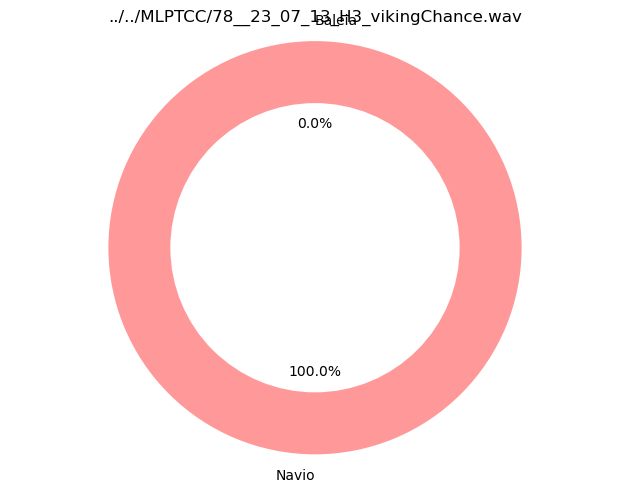

In [15]:
# Carrega o modelo de Rede Neural para distinção Navio vs Baleia
model = keras.models.load_model('modelBaleiasNavios2.h5')

classifications = model.predict(samples) # executa a predição
predicted_labels = np.argmax(classifications, axis=1) # Pegar a classificação com maior probabilidade

# Agora temos a variável final_decision que vai guardar a classificação final e será usado
# para mostrar o veredito de classificação ao usuário

final_decision = ''

# Aqui os pontos classificados serão contabilizados para a decisão entre navios ou baleias

qtd_navios = 0
qtd_baleias = 0
for classif in predicted_labels:
    if classif == 'Navio' or classif == 0:
        qtd_navios += 1
    if classif == 'Baleia' or classif == 1:
        qtd_baleias += 1
        
print(f'Navio = {qtd_navios}')
print(f'Baleia = {qtd_baleias}')

if (qtd_baleias/(qtd_navios+qtd_baleias)) >= 0.6:
    final_decision = "Baleia"
elif (qtd_baleias/(qtd_navios+qtd_baleias)) > 0.4:
    final_decision = "Não identificado"
else:
    final_decision = "Navio"
    
# plotagem da pizza
labels = ['Navio', 'Baleia']
sizes = [qtd_navios, qtd_baleias]

colors = ['#ff9999','#66b3ff']


fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)

# Círculo branco central pra fazer a cara da pizza
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)


ax1.axis('equal')  
plt.tight_layout()


# Salva o plot com timestamp
current_GMT = time.gmtime()
time_stamp = calendar.timegm(current_GMT)

plt.title(file_path)

plt.savefig(f'NavBaleia - {time_stamp}', format='svg')
        
plt.show()

### Passo 6: se o veredito for Baleia ou Não identificado, o algoritmo classificador entrega seu veredito final. Caso contrário ele passa para os classificadores de porte (identificação de navio)

In [ ]:
if final_decision != 'Navio':
    HTML(f"""
    <div class="alert">
      <p>VEREDITO: {final_decision}.</p>
    </div>"""+
    """
    <style>
    .alert {
      padding: 20px;
      background-color: #f44336;
      color: white;
      margin-bottom: 15px;
    }
    </style>
    """)

### Passo 7: sendo Navio, vamos passar o áudio em cada um dos classificadores. O primeiro será o indutivo:

### 7.1: Definição do core do indutivo, ou seja, da classe e funções que irão ler o arquivo .rbf ou .dot para carregar em memória a estrutura de árvore binária com a lógica de classificação do algoritmo indutivo ID3

In [ ]:
class TreeNode:
    def __init__(self, label, error):
        self.label = label
        self.error = error
        self.left = None
        self.right = None
        self.condition = None

def ID3_classifier(samples, file_path = 'Inducer.dot', safe = False, key_path = None):
    def parse_dot(dot_string):
        # Extrai as definições de nós e relacionamentos
        node_defs = re.findall(r'node_(\d+) \[label="([^"]+)"\]', dot_string)
        edges = re.findall(r'node_(\d+)->node_(\d+) \[label="([^"]+)"\]', dot_string)
        
        nodes = {}
        
        # Extrai o label do nó e o erro de cada definiçãoe cria o TreeNode
        for node_def in node_defs:
            node_id, label_error = node_def
            split_label = label_error.split('\\n')
            
            if len(split_label) == 2:
                label, error = split_label
            else:
                label = split_label[0]
                error = None
            
            nodes[node_id] = TreeNode(label, error)

        # Extrai origem, destino, e condição para cada nó e sua ligação
        for edge in edges:
            src_id, tgt_id, label = edge
            if label.startswith('<='):
                nodes[src_id].left = nodes[tgt_id]
                nodes[src_id].condition = float(re.search(r'<= ([\d.]+)', label).group(1))
            else:
                nodes[src_id].right = nodes[tgt_id]

        return nodes['0']

    if safe: # quer dizer que deve aplicar a decodificação
        with open(key_path, 'rb') as key_file:
                key = key_file.read()
        cipher = Fernet(key)
        with open(file_path, 'rb') as file:
            encrypted_data = file.read()

        decrypted_data = cipher.decrypt(encrypted_data)
        # Abaixo se eu desejar escrever o arquivo decifrado
        #with open(output_file_name, 'wb') as file:
        #    file.write(decrypted_data)
        dot_content = decrypted_data.decode('utf-8')
    else:
        with open(file_path, 'r') as file:
                dot_content = file.read()

    #print(dot_content) - fins de debug
    root = parse_dot(dot_content)

    #print(root.label) - fins de debug
    #print(root.left.label) 
    #print(root.right.label) 

    def classificador(root, dicionario):
        #self.root = root # Recebe o nó raíz da árvore com toda ela construída
        #self.dicionario = dicionario # recebe dicionário onde chave é a frequência e valor é o psd
        # Agora o processamento para chegar na classificação

        pointer = root
        while(pointer.condition):
            if dicionario[pointer.label] <= pointer.condition:
                pointer = pointer.left
            else:
                pointer = pointer.right

        classif = pointer.label
        return classif

    classificacoes = []
    for ponto in samples:
        frequency_keys = [f"{i}Hz" for i in range(10, 2010, 10)]
        data_dictionary = {key: value for key, value in zip(frequency_keys, ponto)}
        classificacoes.append(classificador(root, data_dictionary))

    return classificacoes

In [ ]:
# inicialmente temos que multiplicar os valores adquiridos por fator constante para uso do ID3
# conforme configurado anteriormente

resultID3 = samples * 100000000

# Agora o código abaixo irá fazer a leitura do arquivo .rbf junto com sua chave para montar em memória a
# árvore binária de decisão advinda do treino do algoritmo indutivo

classificacoes = ID3_classifier(samples=resultID3,file_path='indutivo.rbf',safe=True,key_path='tcc.key')

### 7.1.2: Criar uma função de plot que vai contar os pontos classificados, aplicar condicionais para classificação e fazer o plot do veredito.

In [ ]:
def create_plot(classificados, plot_name = "default.svg"):
   # Plotagem dos resultados
    classifications = classificados
    grande = 0
    pequeno = 0
    for classif in classifications:
        if classif == 'Navio Grande Porte' or classif == 'Grande Porte' or classif == 0:
            grande += 1
        if classif == 'Navio Pequeno Porte' or classif == 'Pequeno Porte' or classif == 1:
            pequeno += 1
    # plotagem da pizza
    labels = ['Navio Grande Porte', 'Navio Pequeno Porte']
    sizes = [grande, pequeno]

    colors = ['#ff9999','#66b3ff']


    fig1, ax1 = plt.subplots()
    ax1.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)

    # Círculo branco central pra fazer a cara da pizza
    centre_circle = plt.Circle((0,0),0.70,fc='white')
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)


    ax1.axis('equal')  
    plt.tight_layout()


    plt.savefig("output.png", format='png')
    plt.savefig(plot_name, format='svg')

    # Agora o veredito:
    total = grande + pequeno
    if grande > pequeno and (grande/total) >= 0.6:
        return "Navio de Grande Porte"
    elif pequeno > grande and (pequeno/total) >= 0.6:
        return "Navio de Pequeno Porte"
    else:
        return "Inconclusivo"

In [ ]:
# O create_plot executa a análise dos pontos já classificados, atribui veredito
# e mostra gráfico de pizza com os resultados.
final_decision = create_plot(classificacoes,"ID3.svg")

HTML(f"""
<div class="alert">
  <p>VEREDITO: {final_decision}.</p>
</div>"""+
"""
<style>
.alert {
  padding: 20px;
  background-color: #f44336;
  color: white;
  margin-bottom: 15px;
}
</style>
""")

### 7.2: passar pelo classificador MLP com pacote Keras (front-end do TensorFlow)

In [ ]:
model = load_model("modelKeras.h5")
# Predição com Keras
classifications = model.predict(samples) # executa a predição
predicted_labels = np.argmax(classifications, axis=1) # Pegar a classificação com maior probabilidade


final_decision = create_plot(predicted_labels,"kerasMLP.svg") # Cria o plot, salva em imagem svg e no output.png

HTML(f"""
<div class="alert">
  <p>VEREDITO: {final_decision}.</p>
</div>"""+
"""
<style>
.alert {
  padding: 20px;
  background-color: #f44336;
  color: white;
  margin-bottom: 15px;
}
</style>
""")

### 7.3: passar pelo classificador MLP com pacote Scikit-learn

In [ ]:
mlp = carrega_objeto("scikitmlp.pkl")

classifications = mlp.predict(samples)

final_decision = create_plot(classifications,"scikit-learnMLP.svg")

HTML(f"""
<div class="alert">
  <p>VEREDITO: {final_decision}.</p>
</div>"""+
"""
<style>
.alert {
  padding: 20px;
  background-color: #f44336;
  color: white;
  margin-bottom: 15px;
}
</style>
""")


### Passo 8: classificação de áudio adquirido no ensaio prático na Praia dos Anjos - Arraial do Cabo - RJ

### 8.1: DataPrep do áudio selecionado para teste

In [ ]:
file_path = '../ENSAIO/20230801142732.wav'
samples = analyze_audio(file_path, start_seconds = 0, end_seconds = 49)

### 8.2: submissão do áudio para classificação Navio vs Baleia

In [ ]:
# Carrega o modelo de Rede Neural para distinção Navio vs Baleia
model = keras.models.load_model('modelBaleiasNavios2.h5')

classifications = model.predict(samples) # executa a predição
predicted_labels = np.argmax(classifications, axis=1) # Pegar a classificação com maior probabilidade

# Agora temos a variável final_decision que vai guardar a classificação final e será usado
# para mostrar o veredito de classificação ao usuário

final_decision = ''

# Aqui os pontos classificados serão contabilizados para a decisão entre navios ou baleias

qtd_navios = 0
qtd_baleias = 0
for classif in predicted_labels:
    if classif == 'Navio' or classif == 0:
        qtd_navios += 1
    if classif == 'Baleia' or classif == 1:
        qtd_baleias += 1
        
print(f'Navio = {qtd_navios}')
print(f'Baleia = {qtd_baleias}')

if (qtd_baleias/(qtd_navios+qtd_baleias)) >= 0.6:
    final_decision = "Baleia"
elif (qtd_baleias/(qtd_navios+qtd_baleias)) > 0.4:
    final_decision = "Não identificado"
else:
    final_decision = "Navio"
    
# plotagem da pizza
labels = ['Navio', 'Baleia']
sizes = [qtd_navios, qtd_baleias]

colors = ['#ff9999','#66b3ff']


fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)

# Círculo branco central pra fazer a cara da pizza
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)


ax1.axis('equal')  
plt.tight_layout()


# Salva o plot com timestamp
current_GMT = time.gmtime()
time_stamp = calendar.timegm(current_GMT)

plt.title(file_path)

plt.savefig(f'NavBaleia - {time_stamp}', format='svg')
        
plt.show()

### 8.3 - submissão do áudio aos classificadores de porte de embarcação

### 8.3.1 - Algoritmo Indutivo ID3

In [ ]:
# inicialmente temos que multiplicar os valores adquiridos por fator constante para uso do ID3
# conforme configurado anteriormente

resultID3 = samples * 100000000

# Agora o código abaixo irá fazer a leitura do arquivo .rbf junto com sua chave para montar em memória a
# árvore binária de decisão advinda do treino do algoritmo indutivo

classificacoes = ID3_classifier(samples=resultID3,file_path='indutivo.rbf',safe=True,key_path='tcc.key')

# O create_plot executa a análise dos pontos já classificados, atribui veredito
# e mostra gráfico de pizza com os resultados.
final_decision = create_plot(classificacoes,"ID3_ensaio.svg")

HTML(f"""
<div class="alert">
  <p>VEREDITO: {final_decision}.</p>
</div>"""+
"""
<style>
.alert {
  padding: 20px;
  background-color: #f44336;
  color: white;
  margin-bottom: 15px;
}
</style>
""")

### 8.3.2 - MLP com Keras

In [ ]:
model = load_model("modelKeras.h5")
# Predição com Keras
classifications = model.predict(samples) # executa a predição
predicted_labels = np.argmax(classifications, axis=1) # Pegar a classificação com maior probabilidade


final_decision = create_plot(predicted_labels,"kerasMLP_ensaio.svg") # Cria o plot, salva em imagem svg e no output.png

HTML(f"""
<div class="alert">
  <p>VEREDITO: {final_decision}.</p>
</div>"""+
"""
<style>
.alert {
  padding: 20px;
  background-color: #f44336;
  color: white;
  margin-bottom: 15px;
}
</style>
""")

### 8.3.3 - MLP com Scikit-learn

In [ ]:
mlp = carrega_objeto("scikitmlp.pkl")

classifications = mlp.predict(samples)

final_decision = create_plot(classifications,"scikit-learnMLP_ensaio.svg")

HTML(f"""
<div class="alert">
  <p>VEREDITO: {final_decision}.</p>
</div>"""+
"""
<style>
.alert {
  padding: 20px;
  background-color: #f44336;
  color: white;
  margin-bottom: 15px;
}
</style>
""")